<a href="https://colab.research.google.com/github/im-p/synteettinen_data/blob/master/simple_data_categorical_numerical_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN for categorical and numerical data


### imports

In [218]:
import pandas as pd
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")



import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
%tensorflow_version 1.x
print(tf.__version__)

from keras import backend as K
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats

optimizer = Adam(lr=0.0002, beta_1=0.5) # optimizer for gan

1.15.0


### import data

In [219]:
df_simple = pd.read_csv("https://raw.githubusercontent.com/im-p/synteettinen_data/master/weight-height.csv")
df_simple

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801
...,...,...,...
9995,Female,66.172652,136.777454
9996,Female,67.067155,170.867906
9997,Female,63.867992,128.475319
9998,Female,69.034243,163.852461


### Data preprocessing
#### Numerical data

In [220]:
simple_numerical_data = df_simple.select_dtypes("number")
simple_numerical_data

,Height,Weight
0,73.847017,241.893563
1,68.781904,162.310473
2,74.110105,212.740856
3,71.730978,220.042470
4,69.881796,206.349801
...,...,...
9995,66.172652,136.777454
9996,67.067155,170.867906
9997,63.867992,128.475319
9998,69.034243,163.852461


In [221]:
#rescale data between -1 - 1
mms = MinMaxScaler(feature_range = (-1, 1))
simple_numerical_data_rescale = mms.fit_transform(simple_numerical_data)
simple_numerical_data_rescale

array([[ 0.58345676,  0.72627801],
       [ 0.17391658, -0.04904721],
       [ 0.6047288 ,  0.44226253],
       ...,
       [-0.22339823, -0.37868065],
       [ 0.19431948, -0.03402463],
       [-0.37894292, -0.52312263]])

#### Categorical data

In [222]:
#One-hot encode categorical data

simple_categorical = pd.get_dummies(df_simple.Gender)
simple_categorical_columns = simple_categorical.columns #columns for generated df
simple_categorical = simple_categorical.values
simple_categorical

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [223]:
print("simple numerical data shape:", simple_numerical_data_rescale.shape)
print("simple categorical data shape:", simple_categorical.shape)

simple numerical data shape: (10000, 2)
simple categorical data shape: (10000, 2)


## GAN with simple data example
#### Build Generator 
 * Generator takes input noise from latent space and generates categorical and numerical data.
 * Output is combined and fed to the discriminator

In [0]:
def build_generator(categorical_data_shape, numerical_data_shape):
    #noise as input from the latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(8, kernel_initializer="he_uniform")(noise)
    hidden_1 = LeakyReLU(0.2)(hidden_1)
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)

    hidden_2 = Dense(16, kernel_initializer="he_uniform")(hidden_1)
    hidden_2 = LeakyReLU(0.2)(hidden_2)
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)

    #Branch 1 for generating categorical data
    branch_1_hidden_1 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_1_hidden_1 = LeakyReLU(0.2)(branch_1_hidden_1)
    branch_1_hidden_1 = BatchNormalization(momentum = 0.8)(branch_1_hidden_1)

    branch_1_hidden_2 = Dense(64, kernel_initializer="he_uniform")(branch_1_hidden_1)
    branch_1_hidden_2 = LeakyReLU(0.2)(branch_1_hidden_2)
    branch_1_hidden_2 = BatchNormalization(momentum=0.8)(branch_1_hidden_2)
    # Output 1 layer, softmax activation for multi classification. Number of classes
    branch_1_output = Dense(categorical_data_shape, activation="softmax")(branch_1_hidden_2)

    #Branch 2 for generating numerical data
    branch_2_hidden_1 = Dense(32, kernel_initializer="he_uniform")(hidden_2)
    branch_2_hidden_1 = LeakyReLU(0.2)(branch_2_hidden_1)
    branch_2_hidden_1 = BatchNormalization(momentum=0.8)(branch_2_hidden_1)

    branch_2_hidden_2 = Dense(64, kernel_initializer="he_uniform")(branch_2_hidden_1)
    branch_2_hidden_2 = LeakyReLU(0.2)(branch_2_hidden_2)
    branch_2_hidden_2 = BatchNormalization(momentum=0.8)(branch_2_hidden_2)
    #Output 2, sigmoid activation
    branch_2_output = Dense(numerical_data_shape, activation="tanh")(branch_2_hidden_2)

    #Combined output for discriminator
    combined_output = concatenate([branch_1_output, branch_2_output])
    #Return model
    return Model(inputs = noise, outputs = combined_output)


#### Build generator and plot model

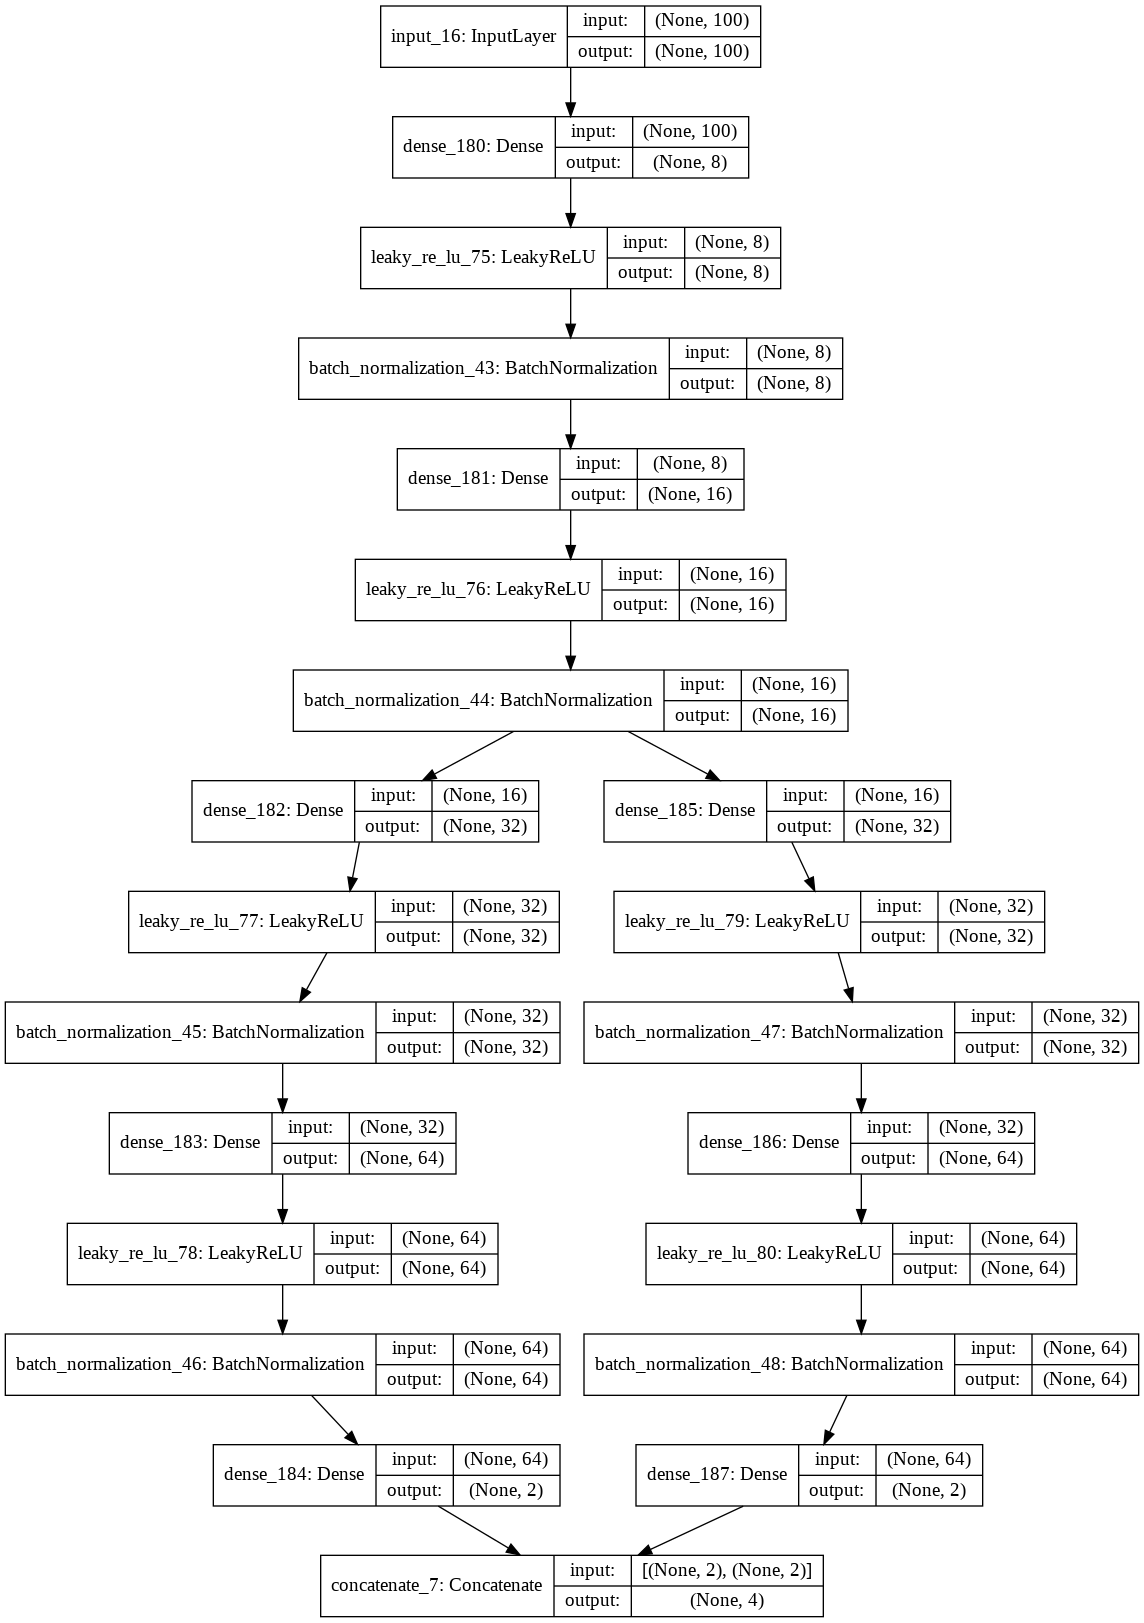

In [225]:
generator = build_generator(simple_categorical.shape[1], simple_numerical_data_rescale.shape[1])
plot_model(generator, show_layer_names = True, show_shapes = True)

#### Build Discriminator
 * Discriminator takes input from the generated data from generator and random real data sample
 * Outputs classification for real or fake

In [0]:
def build_discriminator(inputs_n):
    #Input from generator
    d_input = Input(shape = (inputs_n,))
    d = Dense(128, kernel_initializer="he_uniform")(d_input)
    d = LeakyReLU(0.2)(d)
    d = Dense(64, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(32, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(16, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(8, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    #Discriminator output for classification, sigmoid activation
    d_output = Dense(1, activation = "sigmoid")(d)
    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

#### Build Discriminator, compile and plot model


In [0]:
inputs_n = simple_categorical.shape[1] + simple_numerical_data_rescale.shape[1]

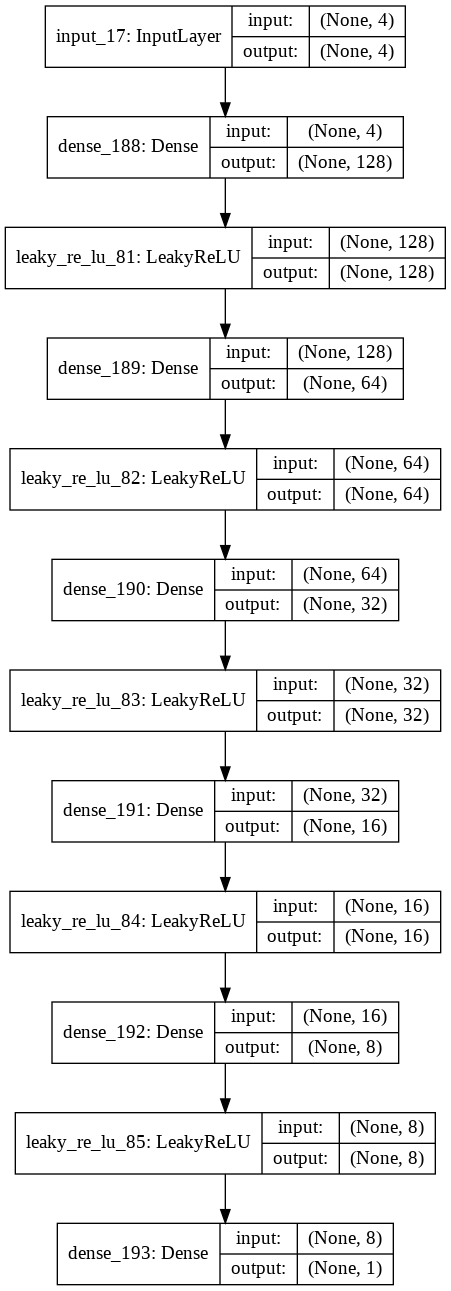

In [228]:
discriminator = build_discriminator(inputs_n)
plot_model(discriminator, show_layer_names = True, show_shapes = True)

#### Build GAN
 * GAN takes input from the latent space (generator input)
 * Outputs classification for real or fake (discriminator output)

In [0]:
def build_gan(generator, discriminator):
    #Make discriminator not trainable
    discriminator.trainable = False
    #Discriminator takes input from generator and make discriminator GAN output
    gan_output = discriminator(generator.output)
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)
    #Compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)
    #Return Model
    return model

#### Build GAN and plot model

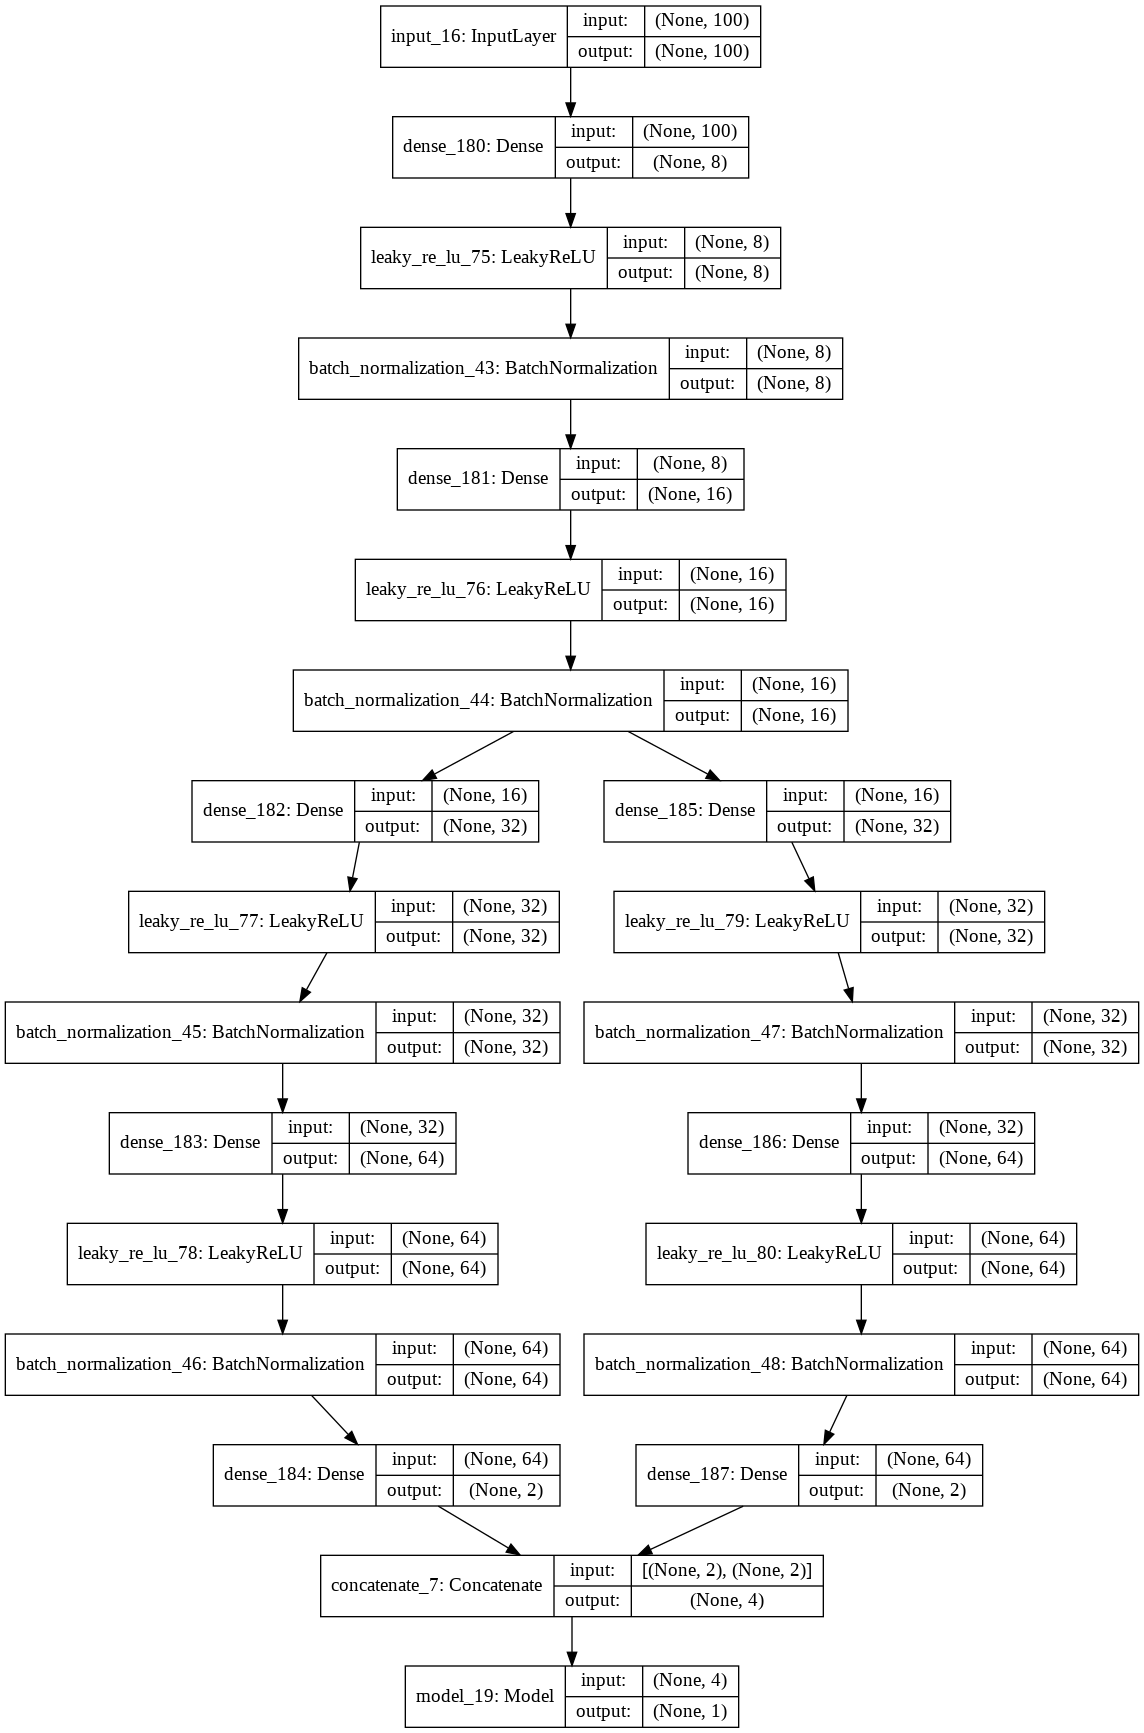

In [230]:
gan = build_gan(generator, discriminator)
plot_model(gan, show_layer_names = True, show_shapes = True)

#### Train GAN

In [0]:
def train(gan, generator, discriminator, categorical_data, numerical_data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)
    #lists for stats from the model
    discriminator_loss = []
    generator_loss = []
    dis_acc_real = []
    dis_acc_fake = []
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    #training loop
    for i in range(n_epochs):
        #select random batch from the real categorical data
        idx = np.random.randint(0, categorical_data.shape[0], half_batch)
        categorical_real = categorical_data[idx]
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, numerical_data.shape[0], half_batch)
        numerical_real = numerical_data[idx]
        
        #concatenate categorical and numerical data for discriminator input
        real_data = np.concatenate([categorical_real, numerical_real], axis = 1)
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)
        dis_acc_real.append(d_loss_real)
        dis_acc_fake.append(d_loss_fake)
        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, valid)

        generator_loss.append(g_loss)
        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.plot(dis_acc_real, label = "Discriminator accuracy real")
    plt.plot(dis_acc_fake, label = "Discriminator accuracy fake")
    plt.title("Stats from training GAN")
    plt.legend()

#### Train GAN

Epoch: 1000 [Discriminator loss: 0.692923] [Generator loss: 0.712467]
Epoch: 2000 [Discriminator loss: 0.697799] [Generator loss: 0.728299]
Epoch: 3000 [Discriminator loss: 0.692411] [Generator loss: 0.751145]
Epoch: 4000 [Discriminator loss: 0.685140] [Generator loss: 0.720594]
Epoch: 5000 [Discriminator loss: 0.690417] [Generator loss: 0.715339]


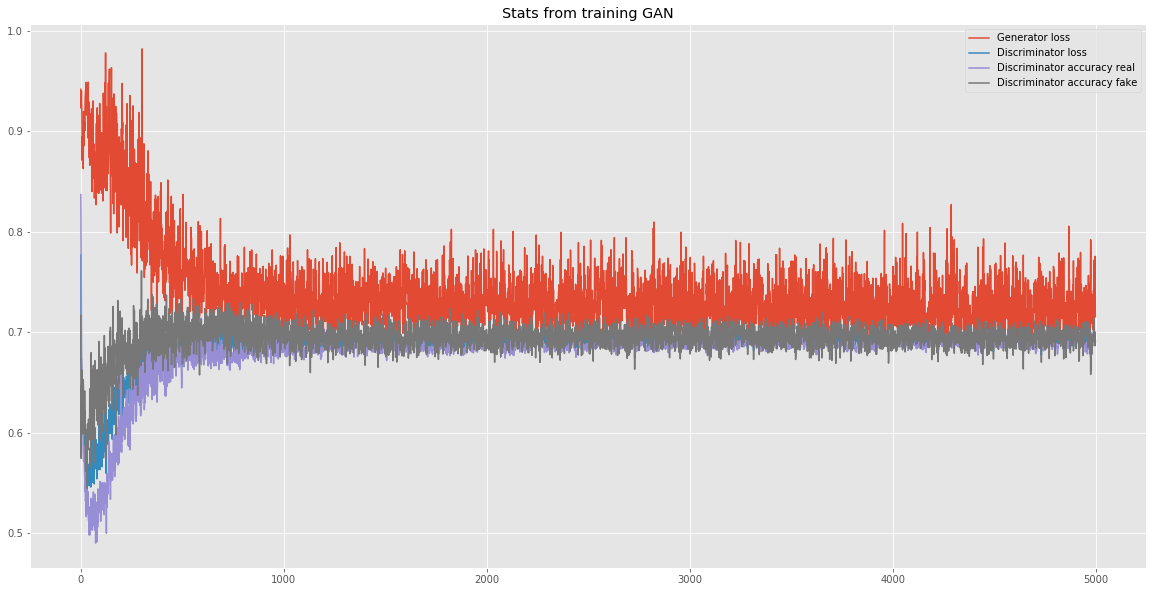

In [232]:
train(gan, generator, discriminator, simple_categorical, simple_numerical_data_rescale, latent_dim = 100, n_epochs = 5000, n_batch = 256, n_eval = 1000)

### Use generator to generate new samples from the noise




In [233]:
noise = np.random.normal(0, 1, (10000, 100))
simple_generated_data = generator.predict(noise)
simple_generated_data

array([[ 6.29505901e-20,  1.00000000e+00,  3.10869634e-01,
         2.73637474e-01],
       [ 1.00000000e+00,  3.18404255e-19, -4.99651521e-01,
        -4.67692286e-01],
       [ 1.00000000e+00,  3.09563436e-24,  1.12279154e-01,
         1.63798660e-01],
       ...,
       [ 1.00000000e+00,  5.47925469e-24,  4.79732007e-01,
         2.50959843e-01],
       [ 1.00000000e+00,  5.36006092e-28,  2.30231509e-01,
         1.82574436e-01],
       [ 6.00181987e-19,  1.00000000e+00,  3.18920106e-01,
         3.20909560e-01]], dtype=float32)

In [234]:
#generated data to dataframe
simple_colnames = list(simple_categorical_columns) + list(simple_numerical_data)
simple_gen_df = pd.DataFrame(data = simple_generated_data, columns = simple_colnames)
simple_gen_df

,Female,Male,Height,Weight
0,6.295059e-20,1.000000e+00,0.310870,0.273637
1,1.000000e+00,3.184043e-19,-0.499652,-0.467692
2,1.000000e+00,3.095634e-24,0.112279,0.163799
3,1.000000e+00,7.136501e-13,-0.351527,-0.299859
4,6.393774e-21,1.000000e+00,0.059552,-0.057347
...,...,...,...,...
9995,1.000000e+00,2.755818e-22,0.360407,0.162550
9996,1.760810e-21,1.000000e+00,0.635435,0.598600
9997,1.000000e+00,5.479255e-24,0.479732,0.250960
9998,1.000000e+00,5.360061e-28,0.230232,0.182574


### Rescale numerical data and round categorical data

In [235]:
#numerical data rescaleing
simple_gen_df.iloc[:,2:] = mms.inverse_transform(simple_gen_df.iloc[:,2:])
simple_gen_df

,Female,Male,Height,Weight
0,6.295059e-20,1.000000e+00,70.475716,195.432373
1,1.000000e+00,3.184043e-19,60.451347,119.338737
2,1.000000e+00,3.095634e-24,68.019585,184.157990
3,1.000000e+00,7.136501e-13,62.283325,136.565994
4,6.393774e-21,1.000000e+00,67.367462,161.458557
...,...,...,...,...
9995,1.000000e+00,2.755818e-22,71.088387,184.029831
9996,1.760810e-21,1.000000e+00,74.489876,228.788055
9997,1.000000e+00,5.479255e-24,72.564171,193.104630
9998,1.000000e+00,5.360061e-28,69.478394,186.085220


In [236]:
# round categorical data
simple_gen_df.iloc[:,0:2] = np.round(simple_gen_df.iloc[:,0:2])
simple_gen_df.Female = simple_gen_df.Female.astype("int")
simple_gen_df.Male = simple_gen_df.Male.astype("int")
simple_gen_df

,Female,Male,Height,Weight
0,0,1,70.475716,195.432373
1,1,0,60.451347,119.338737
2,1,0,68.019585,184.157990
3,1,0,62.283325,136.565994
4,0,1,67.367462,161.458557
...,...,...,...,...
9995,1,0,71.088387,184.029831
9996,0,1,74.489876,228.788055
9997,1,0,72.564171,193.104630
9998,1,0,69.478394,186.085220


# Compare generated data to original data
 * normal distribution
 * mean, variance, standard deviation
 * correlation
 * neural network classifier

In [0]:
def normal_distribution(r, f):
	r_x_min = r.min()
	r_x_max = r.max()
	f_x_min = f.min()
	f_x_max = f.max()

	r_mean = r.mean()
	r_std = r.std()
	f_mean = f.mean()
	f_std = f.std()

	r_x = np.linspace(r_x_min, r_x_max, len(r))
	f_x = np.linspace(f_x_min, f_x_max, len(f))

	r_y = scipy.stats.norm.pdf(r_x, r_mean, r_std)
	f_y = scipy.stats.norm.pdf(f_x, f_mean, f_std)
 
	n, bins, patches = plt.hist([r, f], density = True, alpha = 0.5, color = ["black", "red"])
	#plt.hist(f, density = True, alpha = 0.5, color = "red")
	
	xmin, xmax = plt.xlim()

	plt.plot(r_x, r_y, color="black", label = "Original data", alpha = 0.5)
	plt.plot(f_x, f_y, color="red", label = "Generated data", alpha = 0.5)
	title = f"Original data mean {np.round(r_mean, 4)}, Original data std {np.round(r_std, 4)} \nGenerated data mean {np.round(f_mean, 4)}, Generated data {np.round(f_std, 4)}"
	plt.title(title)
	plt.legend()
	plt.grid()
	plt.show()
 

In [238]:
# create original dataframe with dummy variables
df_simple2 = pd.concat([pd.get_dummies(df_simple.Gender), simple_numerical_data], axis = 1)
df_simple2

,Female,Male,Height,Weight
0,0,1,73.847017,241.893563
1,0,1,68.781904,162.310473
2,0,1,74.110105,212.740856
3,0,1,71.730978,220.042470
4,0,1,69.881796,206.349801
...,...,...,...,...
9995,1,0,66.172652,136.777454
9996,1,0,67.067155,170.867906
9997,1,0,63.867992,128.475319
9998,1,0,69.034243,163.852461


In [239]:
print("Real data mean:\n", df_simple2.mean())
print("Real data std:\n", df_simple2.std())
print("Real data var:\n", df_simple2.var())
print("---------------------")
print("Generated data mean:\n", simple_gen_df.mean())
print("Generated data std:\n", simple_gen_df.std())
print("Generated data var:\n", simple_gen_df.var())

Real data mean:
 Female      0.500000
Male        0.500000
Height     66.367560
Weight    161.440357
dtype: float64
Real data std:
 Female     0.500025
Male       0.500025
Height     3.847528
Weight    32.108439
dtype: float64
Real data var:
 Female       0.250025
Male         0.250025
Height      14.803473
Weight    1030.951855
dtype: float64
---------------------
Generated data mean:
 Female      0.501800
Male        0.498200
Height     66.134820
Weight    158.621014
dtype: float64
Generated data std:
 Female     0.500022
Male       0.500022
Height     4.003207
Weight    31.953415
dtype: float64
Generated data var:
 Female       0.250022
Male         0.250022
Height      16.025670
Weight    1021.020761
dtype: float64


Female Normal distribution


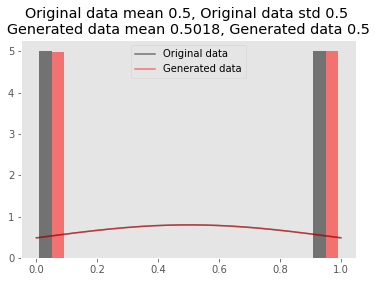

Male Normal distribution


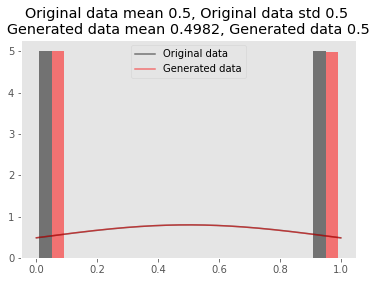

Height Normal distribution


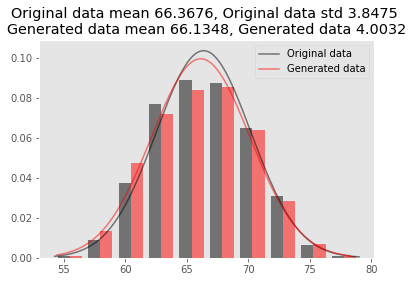

Weight Normal distribution


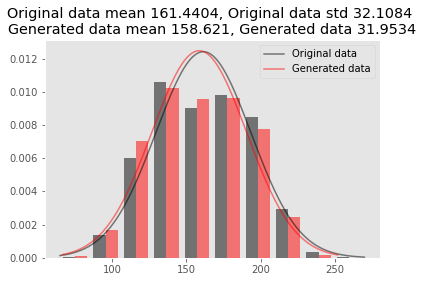

In [240]:
for column in simple_colnames:
    print(column, "Normal distribution")
    normal_distribution(df_simple2[column], simple_gen_df[column])

Original data


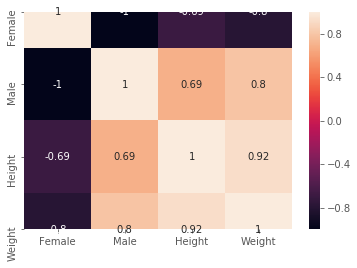

In [241]:
#correlation matrix compareing
print("Original data")
sns.heatmap(df_simple2.corr(), annot = True)

Generated data


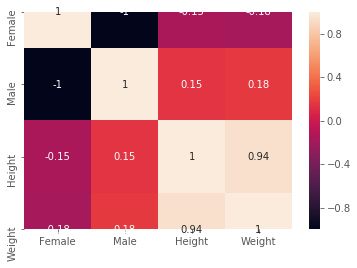

In [242]:
print("Generated data")
sns.heatmap(simple_gen_df.corr(), annot = True)

#### Original data classfier and generated data classifier test

In [0]:
# Neural network classifier for male and female

def classifier():
    model = Sequential()
    model.add(Dense(128, activation = "relu", input_dim = 2))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
    return model

def classifier_train(classifier, x_train, y_train, epoch_limit=100, batch_size=1000):
        
    history = classifier.fit(x_train, y_train, batch_size=batch_size, epochs=epoch_limit, verbose=0)

def evaluate(classifier, x_test, y_test):
    score = classifier.evaluate(x_test, y_test, verbose=1)
    print("Test Loss = {}, Test Accuracy = {}".format(score[0], score[1]))

In [244]:
#generated target labels for classifier
gen_dummies = simple_gen_df.iloc[:, :2]
s = pd.DataFrame(gen_dummies.columns[np.where(gen_dummies != 0)[1]], columns = ["Gender"])
s

,Gender
0,Male
1,Female
2,Female
3,Female
4,Male
...,...
9995,Female
9996,Male
9997,Female
9998,Female


In [245]:
#generated labels
gen_labels = le.fit_transform(s)
gen_labels

array([1, 0, 0, ..., 0, 0, 1])

In [246]:
#original labels
le = LabelEncoder()
labels = le.fit_transform(df_simple.Gender)
labels

array([1, 1, 1, ..., 0, 0, 0])

#### Original data classifier

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_simple2.iloc[:, 2:], labels, test_size = 0.1, random_state = 42)

In [248]:
model = classifier()
classifier_train(model, X_train, y_train)
evaluate(model, X_test, y_test)

1000/1000 [==============================] - 3s 3ms/step
Test Loss = 0.21994669258594512, Test Accuracy = 0.911


#### Generated data classifier

In [0]:
#original data classifier
Xg_train, Xg_test, y_gtrain, y_gtest = train_test_split(simple_gen_df.iloc[:, 2:], gen_labels, test_size = 0.1, random_state = 42)

In [250]:
model = classifier()
classifier_train(model, Xg_train, y_gtrain)
evaluate(model, Xg_test, y_gtest)

1000/1000 [==============================] - 3s 3ms/step
Test Loss = 0.6932179789543151, Test Accuracy = 0.492


## GAN with different architecture

#### Build Generator 
 * Generator takes input noise from latent space and generates categorical and numerical data.
 * Output is NOT combined and fed to discriminator

In [0]:
def build_generator_multi_output(categorical_data_shape, numerical_data_shape):
    #noise as input from the latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(128)(noise)
    hidden_1 = LeakyReLU(0.2)(hidden_1)
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)

    hidden_2 = Dense(256)(hidden_1)
    hidden_2 = LeakyReLU(0.2)(hidden_2)
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)

    #branch 1 for generating categorical data
    branch_1_hidden_1 = Dense(512)(hidden_2)
    branch_1_hidden_1 = LeakyReLU(0.2)(branch_1_hidden_1)
    branch_1_hidden_1 = BatchNormalization(momentum = 0.8)(branch_1_hidden_1)

    branch_1_hidden_2 = Dense(1024)(branch_1_hidden_1)
    branch_1_hidden_2 = LeakyReLU(0.2)(branch_1_hidden_2)
    branch_1_hidden_2 = BatchNormalization(momentum=0.8)(branch_1_hidden_2)
    #output 1 layer, softmax activation for multi classification. Number of classes
    branch_1_output = Dense(categorical_data_shape, activation="softmax")(branch_1_hidden_2)

    #Branch 2 for generating numerical data
    branch_2_hidden_1 = Dense(512)(hidden_2)
    branch_2_hidden_1 = LeakyReLU(0.2)(branch_2_hidden_1)
    branch_2_hidden_1 = BatchNormalization(momentum=0.8)(branch_2_hidden_1)

    branch_2_hidden_2 = Dense(1024)(branch_2_hidden_1)
    branch_2_hidden_2 = LeakyReLU(0.2)(branch_2_hidden_2)
    branch_2_hidden_2 = BatchNormalization(momentum=0.8)(branch_2_hidden_2)
    #output 2, sigmoid activation
    branch_2_output = Dense(numerical_data_shape, activation = "sigmoid")(branch_2_hidden_2)

    model = Model(inputs = noise, outputs = [branch_1_output, branch_2_output])
    #Return model
    return model

In [0]:
generator = build_generator_multi_output(simple_categorical.shape[1], simple_numerical_data_rescale.shape[1])
plot_model(generator, show_layer_names = True, show_shapes = True)

#### Build Discriminator
 * Discriminator takes input from the generated data from generator and random real data sample
 * Outputs classification for real or fake

In [0]:
def build_discriminator_multi_input(categorical_data_shape, numerical_data_shape):
    #Inputs from generator
    categorical_input = Input(shape = (categorical_data_shape,))
    numerical_input = Input(shape = (numerical_data_shape,))
    #categorical classifier
    categorical = Dense(512, kernel_initializer='he_uniform')(categorical_input)
    categorical = LeakyReLU(0.2)(categorical)
    categorical = Dense(256, kernel_initializer='he_uniform')(categorical)
    categorical = LeakyReLU(0.2)(categorical)
    categorical = Dense(128, kernel_initializer='he_uniform')(categorical)
    categorical = LeakyReLU(0.2)(categorical)
    categorical = Dense(categorical_data_shape, kernel_initializer='he_uniform')(categorical)
    categorical = LeakyReLU(0.2)(categorical)
    categorical = Model(categorical_input, categorical)
    

    #numerical classifier
    numerical = Dense(512, kernel_initializer='he_uniform')(numerical_input)
    numerical = LeakyReLU(0.2)(numerical)
    numerical = Dense(256, kernel_initializer='he_uniform')(numerical)
    numerical = LeakyReLU(0.2)(numerical)
    numerical = Dense(128, kernel_initializer='he_uniform')(numerical)
    numerical = LeakyReLU(0.2)(numerical)
    numerical = Dense(numerical_data_shape, kernel_initializer='he_uniform')(numerical)
    numerical = LeakyReLU(0.2)(numerical)
    numerical = Model(numerical_input, numerical)

    #combine output
    merged_output = concatenate([categorical.output, numerical.output])
    merged = Dense(64, kernel_initializer='he_uniform')(merged_output)
    merged = LeakyReLU(0.2)(merged)
    merged = Dense(32, kernel_initializer='he_uniform')(merged)
    merged = LeakyReLU(0.2)(merged)
    merged = Dense(16, kernel_initializer='he_uniform')(merged)
    merged = LeakyReLU(0.2)(merged)
    merged = Dense(8, kernel_initializer='he_uniform')(merged)
    merged = LeakyReLU(0.2)(merged)
    output = Dense(1, activation = "sigmoid")(merged)
  
    model = Model([categorical.input, numerical.input], output)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    #Return model
    return model

In [0]:
discriminator = build_discriminator_multi_input(simple_categorical.shape[1], simple_numerical_data_rescale.shape[1])
plot_model(discriminator, show_layer_names = True, show_shapes = True)

#### Build GAN
 * GAN takes input from the latent space (generator input)
 * Outputs classification for real or fake (discriminator output)

In [0]:
def build_gan(generator, discriminator):
    #Make discriminator not trainable
    discriminator.trainable = False
    #Discriminator takes input from generator and make discriminator GAN output
    gan_output = discriminator(generator.output)
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)
    #Compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)
    #Return Model
    return model

#### Train GAN

In [0]:
def train(gan, generator, discriminator, categorical_data, numerical_data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)
    #lists for stats from the model
    discriminator_loss = []
    generator_loss = []
    dis_acc_real = []
    dis_acc_fake = []
    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    #training loop
    for i in range(n_epochs):
        #select random batch from the real categorical data
        idx = np.random.randint(0, categorical_data.shape[0], half_batch)
        categorical_real = categorical_data[idx]
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, numerical_data.shape[0], half_batch)
        numerical_real = numerical_data[idx]
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        categorical_fake, numerical_fake = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, da_real = discriminator.train_on_batch([categorical_real, numerical_real], valid)
        d_loss_fake, da_fake = discriminator.train_on_batch([categorical_fake, numerical_fake], fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        dis_acc_real.append(d_loss_real)
        dis_acc_fake.append(d_loss_fake)
        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, valid)

        generator_loss.append(g_loss)
        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(dis_acc_real, label = "Discriminator accuracy real")
    plt.plot(dis_acc_fake, label = "Discriminator accuracy fake")
    plt.title("Stats from training GAN")
    plt.legend()

In [0]:
train(gan, generator, discriminator, simple_categorical, simple_numerical_data_rescale, latent_dim = 100, n_epochs = 5000, n_batch = 2000, n_eval = 100)

In [0]:
noise = np.random.normal(0, 1, (10000, 100))
gen_cat, gen_num = generator.predict(noise)
simple_gen_df2 = np.concatenate([gen_cat, gen_num], axis = 1)
simple_gen_df2

In [0]:
simple_gen_df2 = pd.DataFrame(data = simple_gen_df2, columns = simple_colnames)
simple_gen_df2

In [0]:
#numerical data rescaleing
simple_gen_df2.iloc[:,2:] = mms.inverse_transform(simple_gen_df2.iloc[:,2:])
simple_gen_df2

In [0]:
simple_gen_df2.iloc[:,0:2] = np.round(simple_gen_df2.iloc[:,0:2])
simple_gen_df2.Female = simple_gen_df2.Female.astype("int")
simple_gen_df2.Male = simple_gen_df2.Male.astype("int")
simple_gen_df2

In [0]:
print("Real data mean:\n", df_simple2.mean())
print("Real data std:\n", df_simple2.std())
print("Real data var:\n", df_simple2.var())
print("---------------------")
print("Generated data mean:\n", simple_gen_df2.mean())
print("Generated data std:\n", simple_gen_df2.std())
print("Generated data var:\n", simple_gen_df2.var())

In [0]:
for column in simple_colnames:
    print(column, "Normal distribution")
    normal_distribution(df_simple2[column], simple_gen_df2[column])

In [0]:
#correlation matrix compareing
print("Original data")
sns.heatmap(df_simple2.corr(), annot = True)

In [0]:
#correlation matrix compareing
print("Original data")
sns.heatmap(simple_gen_df2.corr(), annot = True)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_simple2.iloc[:, 2:], df_simple2.iloc[:, :2], test_size = 0.1, random_state = 42)

In [0]:
model = classifier()
model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
classifier_train(model, X_train, y_train)
evaluate(model, X_test, y_test)

In [0]:
Xg_train, Xg_test, y_gtrain, y_gtest = train_test_split(simple_gen_df2.iloc[:, 2:], simple_gen_df2.iloc[:, :2], test_size = 0.1, random_state = 42)

In [0]:
evaluate(model, Xg_test, y_gtest)